### Seeded Graph Matching (SGM)
Seeded Graph Matching (SGM) is a version of the graph matching problem where one is first given a partial alignment of the nodes. This algorithm is an modification of the Fast Approximate QAP (FAQ) algorithm (Vogelstein, 2015), as described in Seeded graph matching (Fishkind, 2018). For a more in depth explanation of the graph matching problem and FAQ, view the FAQ tutorial.

https://microsoft.github.io/graspologic/tutorials/aligning/aligning.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
np.random.seed(8888)

To demonstrate the effectiveness of SGM, the algorithm will be applied on a pair of correlated SBM graphs 
(undirected, no self loops) with the following parameters: 
    
n = [100, 100, 100] 

rho = 0.9

p= [.7 .3 .4, .3 .7 .3, .4 .3 .7]

In [5]:
from graspologic.match import GraphMatch as GMP
from graspologic.plot import heatmap
from graspologic.simulations import er_corr, sbm, sbm_corr

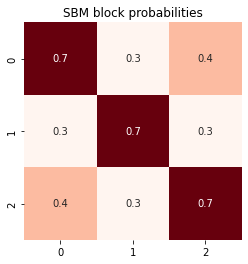

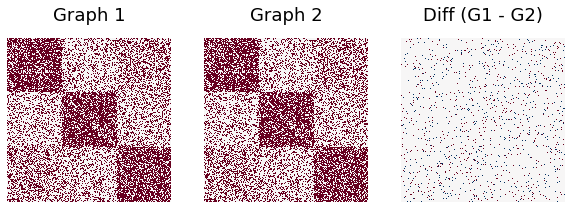

In [6]:
directed = False
loops = False
n_per_block = 75
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
n_verts = block_members.sum()
rho = .9
block_probs = np.array([[0.7, 0.3, 0.4], [0.3, 0.7, 0.3], [0.4, 0.3, 0.7]])
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.heatmap(block_probs, cbar=False, annot=True, square=True, cmap="Reds", ax=ax)
ax.set_title("SBM block probabilities")

A1, A2 = sbm_corr(block_members, block_probs, rho, directed=directed, loops=loops)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
heatmap(A1, ax=axs[0], cbar=False, title="Graph 1")
heatmap(A2, ax=axs[1], cbar=False, title="Graph 2")
_ = heatmap(A1 - A2, ax=axs[2], cbar=False, title="Diff (G1 - G2)")



To demonstrate the effectiveness of SGM, as well as why having seeds is important, 
we will randomly shuffle the vertices of Graph 2. 

This random permutation is stored, 
and unshuffled, such that we have available the optimal permutation that returns the original graph 2.

## Shuffling graph 2 

### Here we see that after shuffling graph 2, there are many more edge disagreements, as expected.

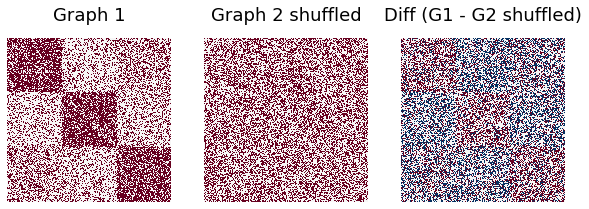

In [7]:
node_shuffle_input = np.random.permutation(n_verts)
A2_shuffle = A2[np.ix_(node_shuffle_input, node_shuffle_input)]
node_unshuffle_input = np.array(range(n_verts))
node_unshuffle_input[node_shuffle_input] = np.array(range(n_verts))

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
heatmap(A1, ax=axs[0], cbar=False, title="Graph 1")
heatmap(A2_shuffle, ax=axs[1], cbar=False, title="Graph 2 shuffled")
_ = heatmap(A1 - A2_shuffle, ax=axs[2], cbar=False, title="Diff (G1 - G2 shuffled)")

## Unshuffling graph 2 with 10 seeds
Next, we will run SGM with 10 seeds randomly selected from the optimal permutation vector found ealier. Although 10 seeds is only about 4% of the 300 node graph, we will observe below how much more accurate the matching will be compared to having no seeds.

Match Ratio with 10 seeds:  1.0


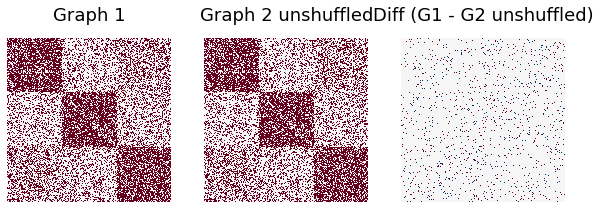

In [8]:
W1 = np.sort(random.sample(list(range(n_verts)),10))
W1 = W1.astype(int)
W2 = np.array(node_unshuffle_input[W1])

sgm = GMP()
sgm = sgm.fit(A1,A2_shuffle,W1,W2)
A2_unshuffle = A2_shuffle[np.ix_(sgm.perm_inds_, sgm.perm_inds_)]

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
heatmap(A1, ax=axs[0], cbar=False, title="Graph 1")
heatmap(A2_unshuffle, ax=axs[1], cbar=False, title="Graph 2 unshuffled")
heatmap(A1 - A2_unshuffle, ax=axs[2], cbar=False, title="Diff (G1 - G2 unshuffled)")

match_ratio = 1-(np.count_nonzero(abs(sgm.perm_inds_-node_unshuffle_input))/n_verts)
print("Match Ratio with 10 seeds: ", match_ratio)

From the results above, we see that when running SGM on the same two graphs, with no seeds there is match ratio is quite low. However including 10 seeds increases the match ratio to 100% (meaning that the shuffled graph 2 was completely correctly unshuffled).

### Omnibus Embedding for Multiple Graphs

This demo shows you how to simultaneously embed two graphs using omnibus embedding from two graphs sampled from different stochastic block models (SBM). We will also compare the results to that of adjacency spectral embedding, and show why it is useful to embed the graphs simultaneously.

In [11]:
import graspologic

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

We sample 2-block SBMs (undirected, no self-loops) with 50 vertices, each block containing 25 vertices (n = [25, 25]), and the following block probabilities:

The only difference between the two are the block probability for the second block. We sample
and .

In [12]:
from graspologic.simulations import sbm

m = 50
n = [m, m]
P1 = [[.3, .1],
      [.1, .7]]
P2 = [[.3, .1],
      [.1, .3]]

np.random.seed(8)
G1 = sbm(n, P1)
G2 = sbm(n, P2)

## Visualize the graphs using heatmap

We visualize the sampled graphs using heatmap function. Heatmap will plot the adjacency matrix, where the colors represent the weight of the edge. In this case, we have binary graphs so the values will be either 0 or 1.

There is clear block structure to the graphs, and we see that the second, lower right, block of G1
has more edges than that of G2.



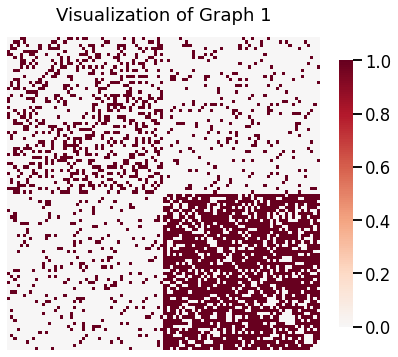

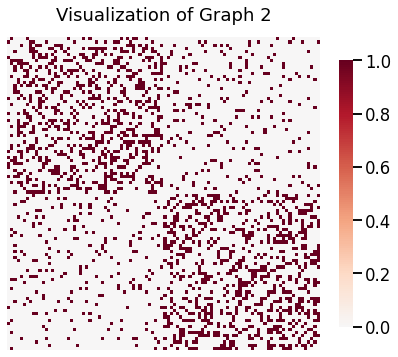

In [13]:
from graspologic.plot import heatmap

heatmap(G1, figsize=(7, 7), title='Visualization of Graph 1')
_ = heatmap(G2, figsize=(7, 7), title='Visualization of Graph 2')

## Embed the two graphs using omnibus embedding

The purpose of embedding graphs is to obtain a Euclidean representation, sometimes called latent positions, of the adjacency matrices. Again, we assume that the probability matrix of a graph is given by P = XXT and we are trying to estimate X. The benefit of omnibus embedding is that the latent positions of all embedded graphs live in the same canonical space, thus eliminating the need to align the results.

We use all of the default parameters. Underneath, the select_dimension algorithm will automatically find the optimal embedding dimension for us. In this example, we get the following estimate,

where the first block,
X~1, are the latent positions of the first graph, and the second block, X~2, are the latent positions of the second graph.

In [14]:
from graspologic.embed import OmnibusEmbed

embedder = OmnibusEmbed()
Zhat = embedder.fit_transform([G1, G2])

print(Zhat.shape)

(2, 100, 2)


## Visualize the latent positions

    
Since the two graphs have clear block structures, we should see two “clusters” when we visualize
the latent positions. The vertices that form the first block should be close together since they
have the same block probabilities, while those that form the second block should be further apart
since they have different block probabilities.    
    
    

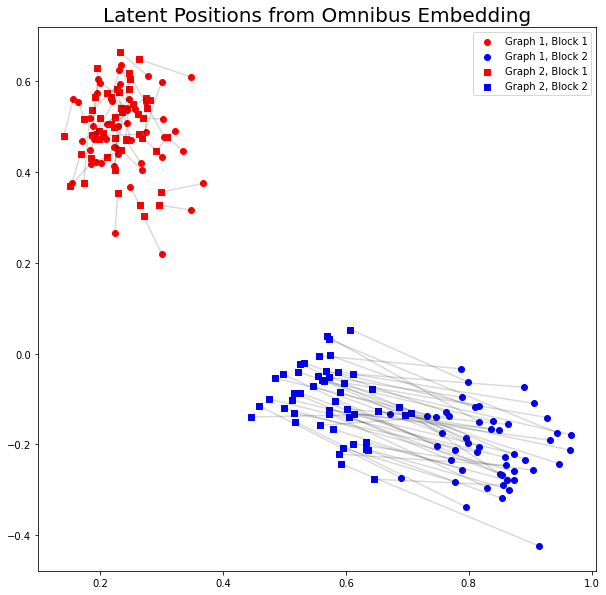

In [16]:
Xhat1 = Zhat[0]
Xhat2 = Zhat[1]

# Plot the points
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(Xhat1[:m, 0], Xhat1[:m, 1], marker='o', c='red', label = 'Graph 1, Block 1')
ax.scatter(Xhat1[m:, 0], Xhat1[m:, 1], marker='o', c='blue', label = 'Graph 1, Block 2')
ax.scatter(Xhat2[:m, 0], Xhat2[:m, 1], marker='s', c='red', label = 'Graph 2, Block 1')
ax.scatter(Xhat2[m:, 0], Xhat2[m:, 1], marker='s', c='blue', label= 'Graph 2, Block 2')
ax.legend()

# Plot lines between matched pairs of points
for i in range(2*m):
    ax.plot([Xhat1[i, 0], Xhat2[i, 0]], [Xhat1[i, 1], Xhat2[i, 1]], 'black', alpha = 0.15)

_ = ax.set_title('Latent Positions from Omnibus Embedding', fontsize=20)

## Spectral Vertex Nomination

This demo shows how to use the Spectral Vertex Nomination (SVN) class. We will use SVN to nominate vertices in a Stochastic Block Model (SBM)

In [17]:
# imports
import numpy as np
from graspologic.nominate import SpectralVertexNomination
from graspologic.simulations import sbm
from graspologic.plot import heatmap
from matplotlib import pyplot as plt

%matplotlib inline

Given a graph G = (V,E) and a subset of V called S (the “seed”), Single Graph Vertex Nomination is the problem of ranking all V ordered by degree of relation to members of S. 

Spectral Vertex Nomination (SVN) solves the Vertex Nomination problem by embedding a graph’s adjacency matrix into a low dimensional euclidean space, then using distance based methods to establish relationship between vertices. (See embedding tutorials)

SVN has the advantage of being extremely efficient on very large graphs, and requires very little prior knowledge of a graph’s properties or structure. However, it does somewhat conflate the notion of community membership with vertex similarity. This might not be appropriate for all vertex nomination use cases. Synthetic SBM data, with inherently defined communities, is therefore a good setting for demonstrating SVN.

C:\Users\15043\AppData\Local\Temp\ipykernel_33588\2696550744.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  adj = np.array(sbm(3 * [n_verts], p), dtype=np.int)


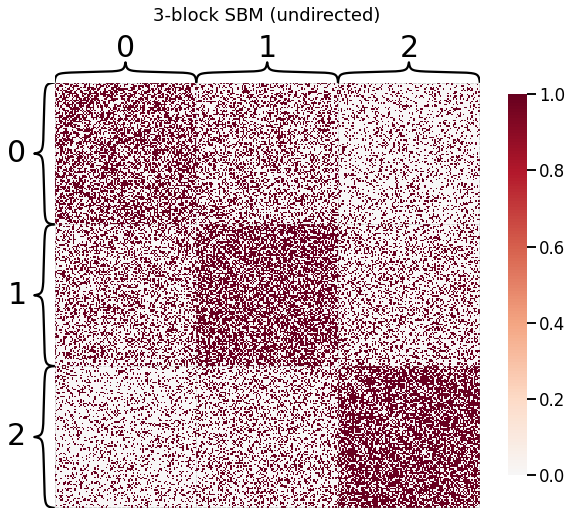

In [18]:
# construct graph from sbm
n_verts = 100
p = np.array([[0.5, 0.35, 0.2],
              [0.35, 0.6, 0.3],
              [0.2, 0.3, 0.65]])
labels = np.array([0] * n_verts + [1] * n_verts + [2] * n_verts)
adj = np.array(sbm(3 * [n_verts], p), dtype=np.int)
fig = heatmap(adj, title='3-block SBM (undirected)', inner_hier_labels=labels)

There are two cases of single graph vertex nomination. In the unattributed case, the seed is simply a list of any number of vertices in the graph . For each seed vertex , SVN will return a list of the other vertices in order of distance to

. Any distance metric supported by sklearn’s NearestNeighbors can be used, euclidean is default and is generally sufficient.

The n_neighbors argument can be used to specify how many vertices should be nominated for each seed, otherwise all vertices will be ranked for each seed. Setting n_neighbors will improve runtime on large graphs and might also improve prediction accuracy in some cases.

In [19]:
# instantiate a default SVN
svn = SpectralVertexNomination(n_neighbors=5)
# fit to the adjacency matrix
svn.fit(X=adj)

SpectralVertexNomination(n_neighbors=5)

The predict method takes a numpy array of seed vertex indices as an argument. It generates the nomination list, and returns a tuple of the nomination list itself and the associated distance matrix.

Here, we select a seed of 5 random vertices, and the top 5 vertices nominated for each seed are plotted along the first two dimensions of the embedded space.

C:\Users\15043\AppData\Local\Temp\ipykernel_33588\1663984528.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seed = np.random.choice(3 * n_verts, size=5, replace=False).astype(np.int)


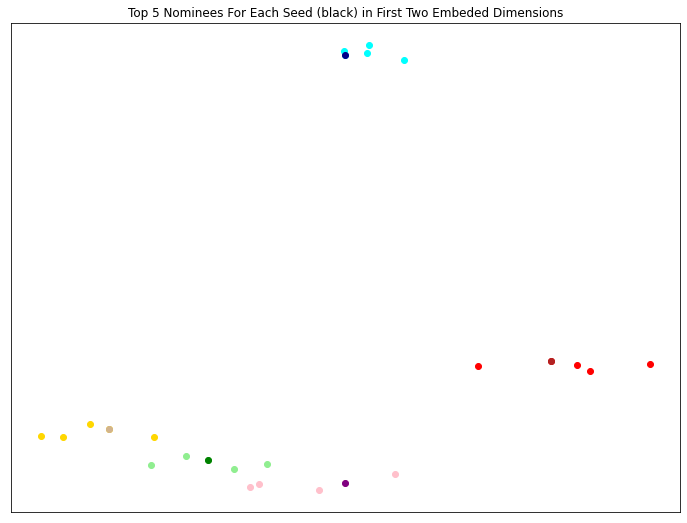

In [20]:
# define the seed as a random sample of 5 vertices from V.
seed = np.random.choice(3 * n_verts, size=5, replace=False).astype(np.int)
nomination_matrix, distance_matrix = svn.predict(seed)

color = ['red', 'lightgreen', 'gold', 'cyan', 'pink']
seed_color = ['firebrick', 'green', 'tan', 'darkblue', 'purple']
plt.figure(figsize=(12, 9))
for i in range(nomination_matrix.shape[1]):
    plt.scatter(svn.embedding_[nomination_matrix[:, i], 0],
                svn.embedding_[nomination_matrix[:, i], 1],
                c=color[i])
    plt.scatter(svn.embedding_[seed[i], 0],
            svn.embedding_[seed[i], 1],
            c=seed_color[i])
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('Top 5 Nominees For Each Seed (black) in First Two Embeded Dimensions')

The attributed case is not currently handled by Graspologic, and may be added in the future.

## Aligning 
align is a module that can be used to align two different datasets. In particular, all three currently existing classes, namely SignFlips, regular OrthogonalProcrustes, and SeedlessProcrustes are aimed at correcting an orthogonal transformation of the data, the exact form of which is unknwon. The motivation for this are orthogonal non-identifiabilities, which are common when dealing with various embedding methods, whether in statistical graphs or other domains. Noted that if two graphs are embedded using omnibus embedding - they don’t need to be aligned.

Recall that an orthogonal matrix is any matrix Q
such that QTQ = I. For all alignment methods, the main idea is to infer an orthogonal matrix Q from the input data sets X and Y, and subsequently use Q in order to align X to Y, by transforming X as
X~ = XQ. The major differences among classes in align come from the settings in which they are applicable, as well as additional assumptions made on the matrix Q.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from graspologic.plot import heatmap
from scipy.stats import special_ortho_group, ortho_group

%matplotlib inline

## Simple rotation example
First, let’s build two simple datasets X and Y, with all entries of X coming from the UNIFORM(0,1) distribution, and Y is a copy of X, and subsequently rotated around the origin, using the randomly generated matrix Q, displayed below:

In [22]:
np.random.seed(314)
X = np.random.uniform(0, 1, (15, 2))
Q = special_ortho_group.rvs(2)
Y = X @ Q

array([[-0.94924938, -0.31452442],
       [ 0.31452442, -0.94924938]])

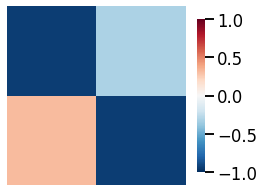

In [23]:
heatmap(Q, figsize=(4,4), vmin=-1, vmax=1)
Q

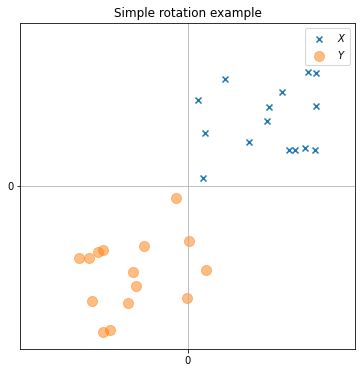

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("Simple rotation example")
ax.scatter(X[:,0], X[:,1], label=r"$X$", marker='x')
ax.scatter(Y[:,0], Y[:,1], label=r"$Y$", s=100, alpha=0.5)
ax.set(xlim=(-1.20, 1.20), ylim=(-1.20, 1.20))
ax.set_xticks([0])
ax.set_yticks([0])
ax.legend()
ax.grid();


## SignFlips
SignFlips assumes that Q is not only orthogonal, but also diagonal, which constraints to matrices with +-1 along the diagonal and 0 everywhere else. In essence, it flips the dataset along some axes such that the two datasets end up in the same orthant (generalized quadrant). Which quadrant the dataset is “located” in is defined by some criterion, which is the dimension-wise medians by default. If the dataset needs to flip along some dimension, the corresponding entry in Q will be -1, and 1 otherwise.

In [25]:
from graspologic.align import SignFlips
aligner_SF = SignFlips()
X_prime_SF = aligner_SF.fit_transform(X, Y)

Since X is entirely in the first quadrant, its dimension-wise medians in both dimensions are greater than 0. Meanwhile Y is predominantly in the third quadrant, so its dimension-wise medians are all smaller than 0. Thus X needs to be flipped both along the x-axis and y-axis in order for two datasets to arive to the same quandrant. So, the Qsf that the algorithm finds is

array([[-1,  0],
       [ 0, -1]])

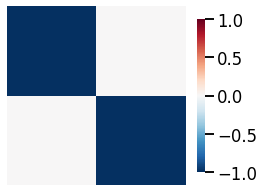

In [26]:
heatmap(aligner_SF.Q_, figsize= (4,4), vmin=-1, vmax=1)
aligner_SF.Q_

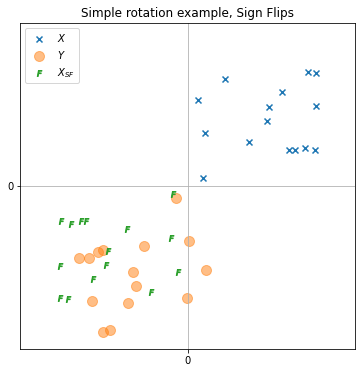

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("Simple rotation example, Sign Flips")
ax.scatter(X[:,0], X[:,1],
           label=r"$X$", marker='x')
ax.scatter(Y[:,0], Y[:,1],
           label=r"$Y$", s=100, alpha=0.5)
ax.scatter(X_prime_SF[:,0],
           X_prime_SF[:,1],
           label=r"$X_{SF}$",
           marker='$F$')
ax.set(xlim=(-1.20, 1.20), ylim=(-1.20, 1.20))
ax.set_xticks([0])
ax.set_yticks([0])
ax.legend()
ax.grid();

SignFlips correctly brings X to the third quadrant, yet the alignment is imperfect, as it is a heuristic-based method. Note that it does not assume that there is any sort of matching between the entries of X and Y. Indeed, the two datasets need not even be of the same size.

This class can also be used to bring the dataset to the first orthant, if one provides the identity matrix as the second dataset.

## OrthogonalProcrustes

https://microsoft.github.io/graspologic/tutorials/aligning/aligning.html

### Methods for Multiscale Comparative Connectomics¶

This demo shows you how to use methods in graspologic to analyze patterns in brain connectivity in connectomics datasets. We specifically demonstrate methods for identifying differences in edges and vertices across subjects.

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
pd.options.mode.chained_assignment = None
%matplotlib inline

### Load the Duke mouse brain dataset¶

Dataset of 32 mouse connectomes derived from whole-brain diffusion magnetic resonance imaging of four distinct mouse genotypes: BTBR T+ Itpr3tf/J (BTBR), C57BL/6J(B6), CAST/EiJ (CAST), and DBA/2J (DBA2). For each strain, connectomes were generated from eight age-matched mice (N = 8 per strain), with a sex distribution of four males and four females. Each connectome was parcellated using asymmetric Waxholm Space, yielding a vertex set with a total of 332 regions of interest (ROIs) symmetrically distributed across the left and right hemispheres. Within a given hemisphere, there are seven superstructures consisting up multiple ROIs, resulting in a total of 14 distinct communities in each connectome.

In [29]:
from graspologic.datasets import load_mice

# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)

# Get sample parameters
n_subjects = mice.meta["n_subjects"]
n_vertices = mice.meta["n_vertices"]

# Split the set of graphs by genotype
btbr = graphs[mice.labels == "BTBR"]
b6 = graphs[mice.labels == "B6"]
cast = graphs[mice.labels == "CAST"]
dba2 = graphs[mice.labels == "DBA2"]

connectomes = [btbr, b6, cast, dba2]


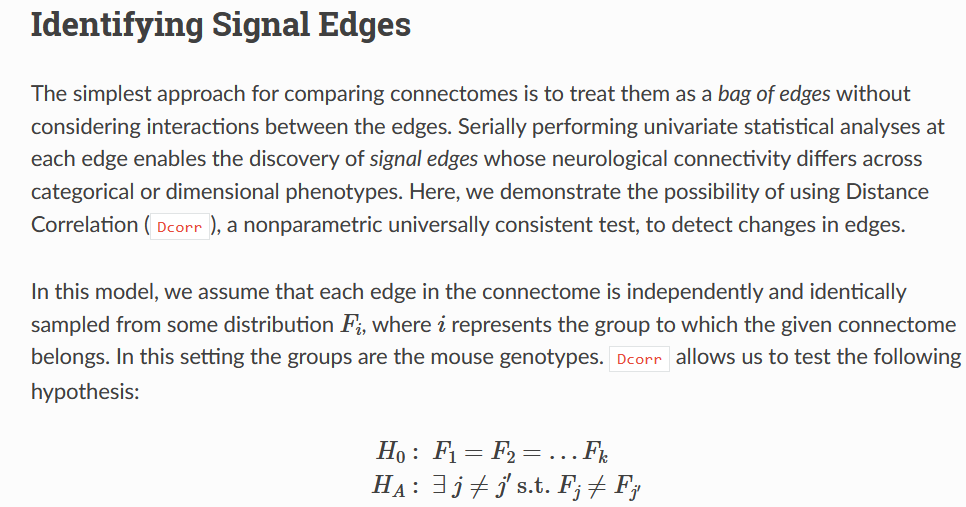

In [30]:
from hyppo.ksample import KSample

Since the connectomes in this dataset are undirected, we only need to do edge comparisons on the upper triangle of the adjacency matrices.

In [31]:
# Make iterator for traversing the upper triangle of the connectome
indices = zip(*np.triu_indices(n_vertices, 1))

edge_pvals = []

for roi_i, roi_j in indices:

    # Get the (i,j)-th edge for each connectome
    samples = [genotype[:, roi_i, roi_j] for genotype in connectomes]

    # Calculate the p-value for the (i,j)-th edge
    try:
        statistic, pvalue = KSample("Dcorr").test(*samples, reps=10000, workers=-1)
    except ValueError:
        # A ValueError is thrown when any of the samples have equal edge
        # weights (i.e. one of the inputs has 0 variance)
        statistic = np.nan
        pvalue = 1

    edge_pvals.append([roi_i, roi_j, statistic, pvalue])


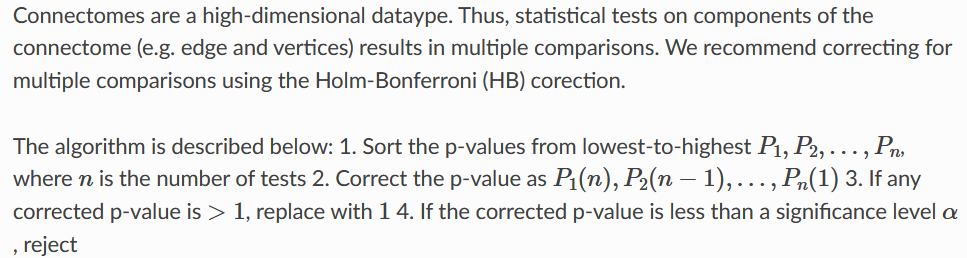

In [32]:
# Convert the nested list to a dataframe
edge_pvals = pd.DataFrame(edge_pvals, columns=["ROI_1", "ROI_2", "stat", "pval"])

# Correct p-values using the Holm-Bonferroni correction
edge_pvals.sort_values(by="pval", inplace=True, ignore_index=True)
pval_rank = edge_pvals["pval"].rank(ascending=False, method="max")
edge_pvals["holm_pval"] = edge_pvals["pval"].multiply(pval_rank)
edge_pvals["holm_pval"] = edge_pvals["holm_pval"].apply(
    lambda pval: 1 if pval > 1 else pval
)

# Test for significance using alpha=0.05
alpha = 0.05
edge_pvals["significant"] = (edge_pvals["holm_pval"] < alpha)

# Get the top 10 strongest signal edges
edge_pvals_top = edge_pvals.head(10)

# Replace ROI indices with actual names
def lookup_roi_name(index):
    hemisphere = "R" if index // 166 else "L"
    index = index % 166
    roi_name = mice.atlas.query(f"ROI == {index+1}")["Structure"].item()
    return f"{roi_name} ({hemisphere})"

edge_pvals_top["ROI_1"] = edge_pvals_top["ROI_1"].apply(lookup_roi_name)
edge_pvals_top["ROI_2"] = edge_pvals_top["ROI_2"].apply(lookup_roi_name)

edge_pvals_top.head()

,ROI_1,ROI_2,stat,pval,holm_pval,significant
0,Corpus_Callosum (L),Striatum (R),0.717036,9.911903e-07,0.054462,False
1,Corpus_Callosum (L),Internal_Capsule (R),0.699473,1.327371e-06,0.072932,False
2,Corpus_Callosum (L),Reticular_Nucleus_of_Thalamus (R),0.698197,1.355858e-06,0.074496,False
3,Corpus_Callosum (L),Zona_Incerta (R),0.685735,1.668308e-06,0.091662,False
4,Septum (R),Corpus_Callosum (R),0.670809,2.139082e-06,0.117525,False


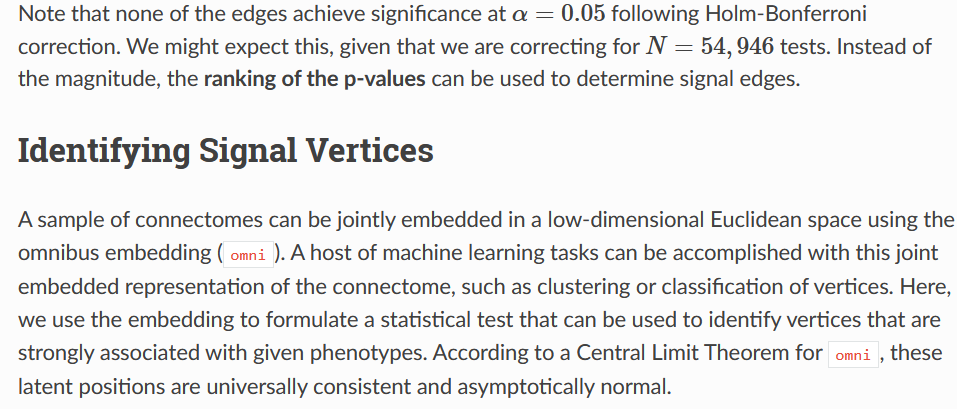

In [33]:
from graspologic.embed import OmnibusEmbed
from graspologic.plot import pairplot

# Jointly embed graphs using omnibus embedding
embedder = OmnibusEmbed()
omni_embedding = embedder.fit_transform(graphs)
print(omni_embedding.shape)



(32, 332, 5)


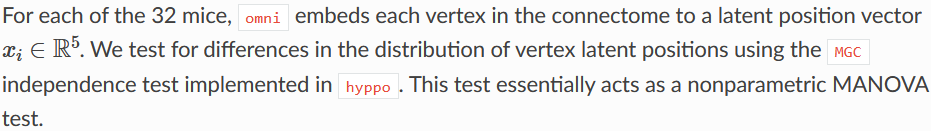

In [34]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", module="hyppo")
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    vertex_pvals = []

    for vertex_i in range(n_vertices):

    # Get the embedding of the i-th vertex for
        samples = [
            omni_embedding[mice.labels==genotype, vertex_i, :]
            for genotype in np.unique(mice.labels)
        ]

    # Calculate the p-value for the i-th vertex
        statistic, pvalue, _ = KSample("MGC").test(
            *samples, reps=250, workers=-1
        )
        vertex_pvals.append([vertex_i, statistic, pvalue])

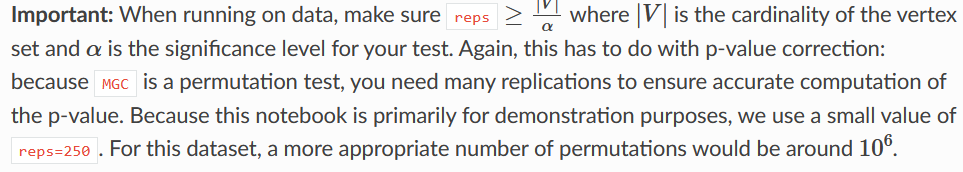

In [35]:
# Convert the nested list to a dataframe
vertex_pvals = pd.DataFrame(vertex_pvals, columns=["ROI", "stat", "pval"])

# Correct p-values using the Holm-Bonferroni correction
vertex_pvals.sort_values(by="pval", inplace=True, ignore_index=True)
pval_rank = vertex_pvals["pval"].rank(ascending=False, method="max")
vertex_pvals["holm_pval"] = vertex_pvals["pval"].multiply(pval_rank)
vertex_pvals["holm_pval"] = vertex_pvals["holm_pval"].apply(
    lambda pval: 1 if pval > 1 else pval
)

# Test for significance using alpha=0.05
alpha = 0.05
vertex_pvals["significant"] = (vertex_pvals["holm_pval"] < alpha)

# Get the top 10 strongest signal edges
vertex_pvals_top = vertex_pvals.head(10)

# Replace ROI indices with actual names
vertex_pvals_top["ROI"] = vertex_pvals_top["ROI"].apply(lookup_roi_name)

vertex_pvals_top.head()

,ROI,stat,pval,holm_pval,significant
0,Cingulate_Cortex_Area_24a (L),0.754901,0.003984,1.0,False
1,Amygdalopiriform_Transition_Area (R),0.526762,0.003984,1.0,False
2,Piriform_Cortex (R),0.603432,0.003984,1.0,False
3,Presubiculum (R),0.292116,0.003984,1.0,False
4,Perirhinal_Cortex (R),0.806250,0.003984,1.0,False


We can use pairplots to visualize the embeddings of specific vertices. Below are pairsplots of the corpus callosum from the left and right hemispheres.

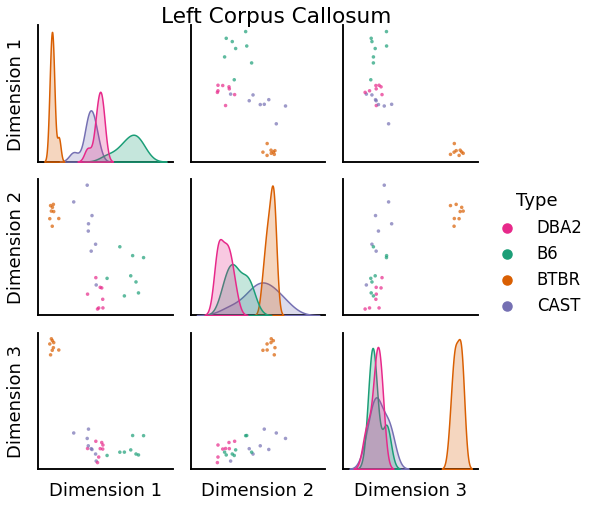

In [37]:
left = pairplot(
    omni_embedding[:, 121 - 1, :3],
    mice.labels,
    palette=["#e7298a", "#1b9e77", "#d95f02", "#7570b3"],
    title="Left Corpus Callosum"
)



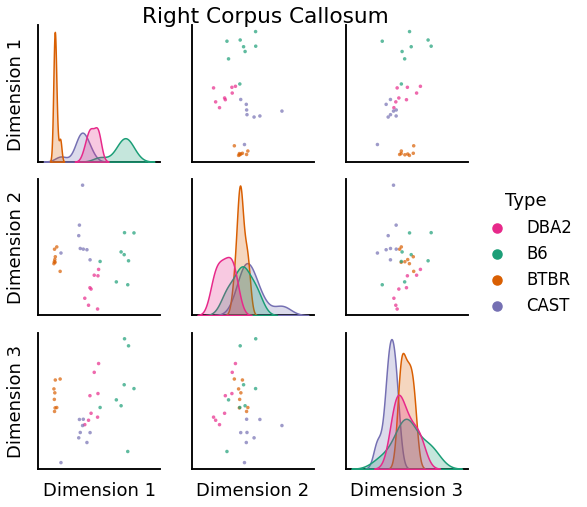

In [38]:
right = pairplot(
    omni_embedding[:, 121 + 166 - 1, :3],
    mice.labels,
    palette=["#e7298a", "#1b9e77", "#d95f02", "#7570b3"],
    title="Right Corpus Callosum",
)

Whole-brain Comparisons¶

We can use the results of the omnibus embedding to perform whole-brain comparisons across subjects from different phenotypes.

In [39]:
from graspologic.embed import ClassicalMDS
from graspologic.plot import heatmap

Two-dimensional representations of each connectome were obtained by using Classical Multidimensional Scaling (cmds) to reduce the dimensionality of the embeddings obtained by omni

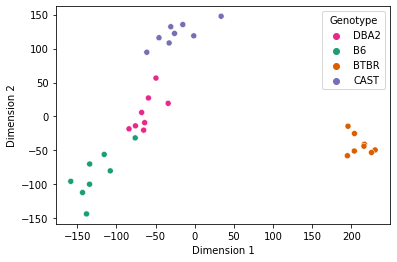

In [40]:
# Further reduce embedding dimensionality using cMDS
cmds = ClassicalMDS(2)
cmds_embedding = cmds.fit_transform(omni_embedding)
cmds_embedding = pd.DataFrame(cmds_embedding, columns=["Dimension 1", "Dimension 2"])
cmds_embedding["Genotype"] = mice.labels

# Embedding with BTBR
sns.scatterplot(
    x="Dimension 1",
    y="Dimension 2",
    hue="Genotype",
    data=cmds_embedding,
    palette=["#e7298a", "#1b9e77", "#d95f02", "#7570b3"],
)
plt.show()

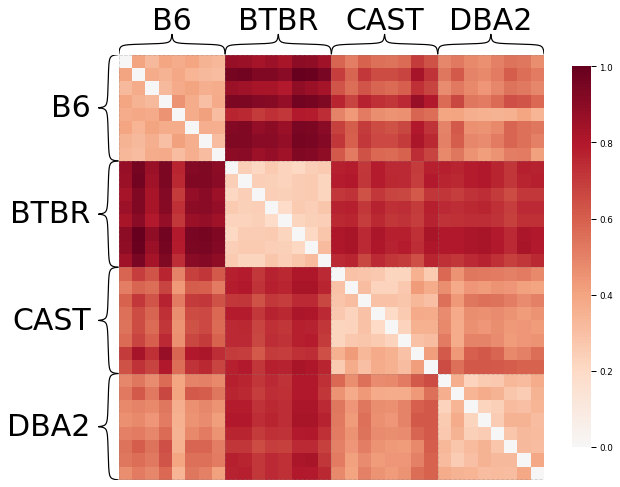

In [41]:
# Find the dissimilarity between subjects' connectomes using the cMDS embedding
dis = cmds.dissimilarity_matrix_
scaled_dissimilarity = dis / np.max(dis)

heatmap(scaled_dissimilarity,
        context="paper",
        inner_hier_labels=mice.labels,)
plt.show()

Notice that mice from the same genotype are most similar to each other, as expected.

In [42]:
import cvxpy


https://github.com/bentoayr/Graph-Matching-Tutorial

https://www.cvxpy.org/examples/

https://cvxpy.readthedocs.io/en/latest/tutorial/intro/

For example, the following code solves a least-squares problem with box constraints:

In [43]:
import cvxpy as cp
import numpy as np

# Problem data.
m = 30
n = 20
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(x.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)

[-1.79109255e-19  2.85112420e-02  2.79973443e-19  3.37658729e-20
 -2.72802663e-19  1.49285011e-01 -9.94082533e-20  8.35373900e-20
  2.46718649e-01  5.78224144e-01 -4.03739463e-19  1.01242860e-03
 -9.28486180e-20  2.26767464e-01 -1.58813678e-19 -8.97232272e-20
 -1.22145729e-19 -1.51509428e-19  1.12060672e-19 -3.48318635e-19]
[ 2.50938945  0.          2.78354615  1.79425782 13.08579183  0.
  0.73716363  3.35344995  0.          0.          8.93825054  0.
  7.02955161  0.          4.71068649  3.18873635  2.06090107 10.08166738
  3.0481157   8.53268239]
